# Importação das bibliotecas

In [127]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   - -------------------------------------- 4.5/124.9 MB 26.9 MB/s eta 0:00:05
   -- ------------------------------------- 8.4/124.9 MB 21.7 MB/s eta 0:00:06
   ---- ----------------------------------- 12.6/124.9 MB 21.9 MB/s eta 0:00:06
   ----- ---------------------------------- 17.0/124.9 MB 21.5 MB/s eta 0:00:06
   ------ --------------------------------- 21.0/124.9 MB 21.0 MB/s eta 0:00:05
   -------- ------------------------------- 25.7/124.9 MB 21.4 MB/s eta 0:00:05
   --------- ------------------------------ 30.1/124.9 MB 21.3 MB/s eta 0:00:05
   ----------- ---------------------------- 34.6/124.9 MB 21.3 MB/s eta 0:00:05
   ------------ --------------------------- 38.8/124.9 MB 21.3 MB/s eta 0:00:05
   ------------- -------------------------- 42.7/124.9 MB 20.9 MB/s eta 0:00:04
   --------------- ------------------------ 47.2/124.9 MB 20.9 MB/s eta 0:00:04
   ---------------- ----------------------- 51.4/12

In [248]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import time

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report
)

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Carregamento dos Dados

- Estavam todos concatenados, apenas separados por ';'.

In [2]:
df_bruto = pd.read_csv("dataset.csv", delimiter=";")

- Apresentação de 10 linhas do dataset

In [3]:
df_bruto.head(10)

,id,issue_date,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,1,2024-10-14 00:00:00.000,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
1,2,2024-10-16 00:00:00.000,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid
2,3,2024-10-15 16:40:24.000,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
3,4,2024-10-17 00:00:00.000,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
4,5,2024-10-07 17:04:16.000,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
5,6,2024-10-04 00:00:00.000,6668.0,False,4.03,5540.4000,2.500000,0.0,0.0,0.0,0.0,0.00,True,AM,valid
6,7,2024-10-17 00:00:00.000,8788.0,False,4.06,1292.7600,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
7,8,2024-10-17 00:00:00.000,8788.0,False,4.06,36544.0680,2.000000,0.0,0.0,1.5,3.0,0.65,False,RO,valid
8,9,2024-10-17 15:09:16.000,974.0,False,10.02,26.6817,2.010000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
9,10,2024-10-14 00:00:00.000,10881.0,True,4.03,1112.7255,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid


# Análise de Dados

- Criação de uma cópia para a análise

In [153]:
df = df_bruto.copy()

## Informações sobre o tipo de cada feature

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           16843 non-null  int64  
 1   issue_date                   16843 non-null  object 
 2   id_supplier                  16675 non-null  float64
 3   iss_retention                16843 non-null  bool   
 4   lc116                        16843 non-null  float64
 5   calculated_value             16843 non-null  float64
 6   iss_tax_rate                 16675 non-null  float64
 7   inss_tax_rate                16843 non-null  float64
 8   csll_tax_rate                16843 non-null  float64
 9   ir_tax_rate                  16843 non-null  float64
 10  cofins_tax_rate              16843 non-null  float64
 11  pis_tax_rate                 16843 non-null  float64
 12  opting_for_simples_nacional  16843 non-null  bool   
 13  state           

- 16843 linhas
- 15 features
    - 10 features numéricas
    - 5 categóricas

## Modificações no Dataset
Algumas modificações foram necessárias para ajudar na análise dos dados.

- Conversão da coluna lc116 para String.

In [154]:
df['lc116'] = df['lc116'].astype(str)
df['lc116']

0         4.03
1         4.12
2        10.02
3         4.03
4         4.09
         ...  
16838     1.07
16839    16.01
16840     1.07
16841     4.02
16842    14.01
Name: lc116, Length: 16843, dtype: object

- Remoção da feature ID

In [155]:
df = df.drop('id', axis = 1)

- Separação das features numéricas e categóricas.

In [10]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns

cat_cols = df.select_dtypes(include=["object", "bool"]).columns

print("Colunas Numéricas:", list(num_cols))
print("Colunas Categóricas:", list(cat_cols))

Colunas Numéricas: ['id_supplier', 'calculated_value', 'iss_tax_rate', 'inss_tax_rate', 'csll_tax_rate', 'ir_tax_rate', 'cofins_tax_rate', 'pis_tax_rate']
Colunas Categóricas: ['issue_date', 'iss_retention', 'lc116', 'opting_for_simples_nacional', 'state', 'class_label']


## Descrição geral das features numéricas

In [87]:
df.describe()

,id_supplier,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate
count,16675.000000,1.684300e+04,16675.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000
mean,5858.570675,6.026261e+03,2.789753,0.171719,0.497456,0.658386,1.527887,0.331529
std,3165.422598,2.909761e+04,2.323147,1.405455,0.538369,0.790466,1.611165,0.350895
min,6.000000,1.083000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3336.000000,5.700000e+02,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5913.000000,1.710000e+03,2.244185,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8520.500000,4.647954e+03,3.292734,0.000000,1.000000,1.500000,3.000000,0.650000
max,11241.000000,1.133142e+06,100.000000,21.446848,1.993938,2.999645,5.997115,2.930112


## Quantidade de valores ausentes

In [6]:
print(df.isnull().sum())

issue_date                       0
id_supplier                    168
iss_retention                    0
lc116                            0
calculated_value                 0
iss_tax_rate                   168
inss_tax_rate                    0
csll_tax_rate                    0
ir_tax_rate                      0
cofins_tax_rate                  0
pis_tax_rate                     0
opting_for_simples_nacional      0
state                          168
class_label                      0
dtype: int64


## Percentual de valores ausentes

In [89]:
print((df.isnull().sum() / len(df)) * 100)

issue_date                     0.000000
id_supplier                    0.997447
iss_retention                  0.000000
lc116                          0.000000
calculated_value               0.000000
iss_tax_rate                   0.997447
inss_tax_rate                  0.000000
csll_tax_rate                  0.000000
ir_tax_rate                    0.000000
cofins_tax_rate                0.000000
pis_tax_rate                   0.000000
opting_for_simples_nacional    0.000000
state                          0.997447
class_label                    0.000000
dtype: float64


- como nas colunas categóricas, os valores ausentes são cerca de 1% dos dados totais, essas linhas com dados ausentes provavelmente serão removidas.

## Valores únicos para colunas categóricas

In [90]:
print(df[cat_cols].nunique())

issue_date                     9303
iss_retention                     2
lc116                           118
opting_for_simples_nacional       2
state                             5
class_label                       2
dtype: int64


- Não será considerada as datas para análise de dados

In [96]:
cat_cols = cat_cols[1:]

- Valores únicos graficamente para cada coluna

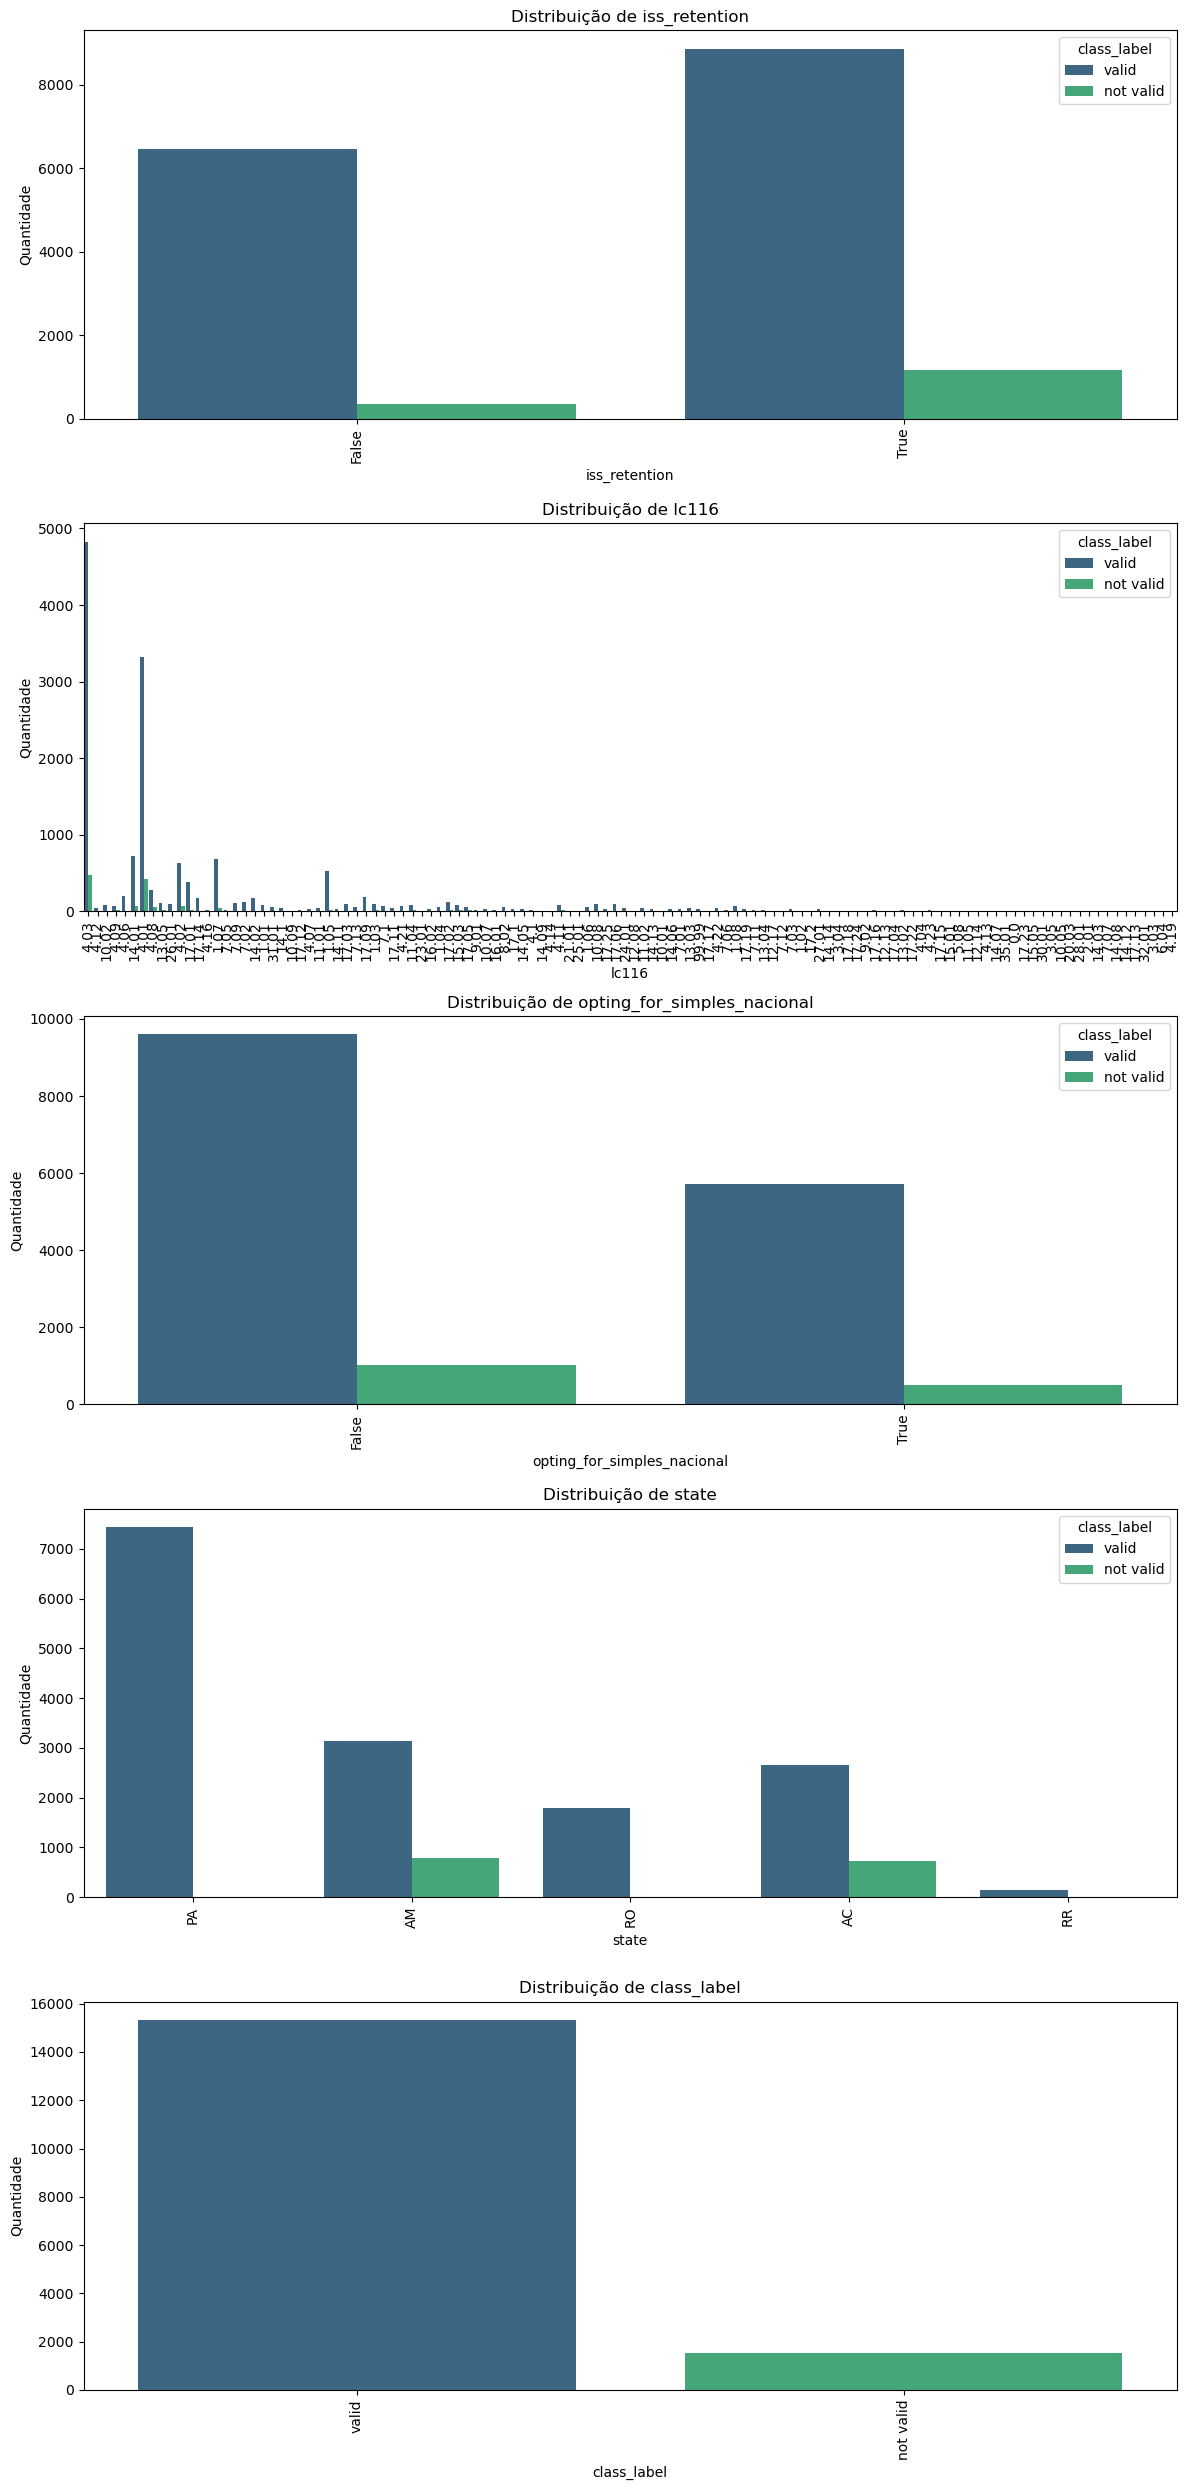

In [74]:
plt.figure(figsize=(12, 5 * len(cat_cols[1:])))

for i, col in enumerate(cat_cols[1:], 1):
    plt.subplot(len(cat_cols[1:]), 1, i)
    sns.countplot(data=df, x=col, palette="viridis", hue="class_label")
    plt.xticks(rotation=90) 
    plt.title(f"Distribuição de {col}")
    plt.xlabel(col)
    plt.ylabel("Quantidade")

plt.tight_layout()
plt.show()

- Verificação da quantidade de itens por rótulos

In [54]:
print(df["class_label"].value_counts())

class_label
valid        15320
not valid     1523
Name: count, dtype: int64


## Histograma para as variáveis numéricas

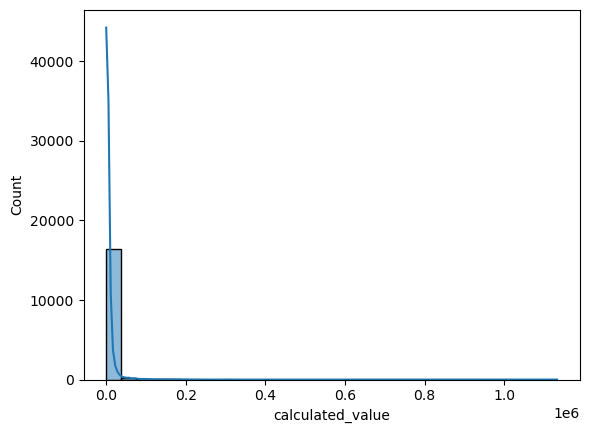

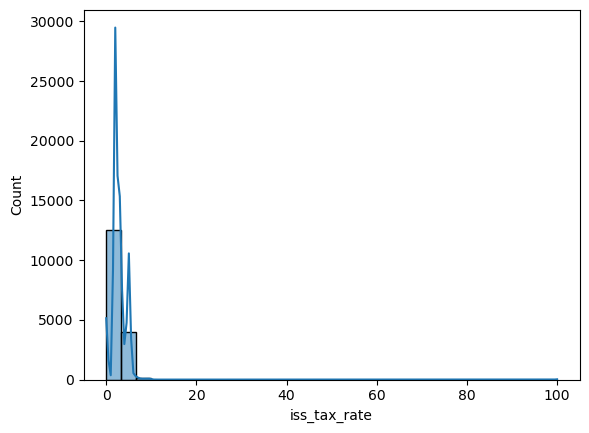

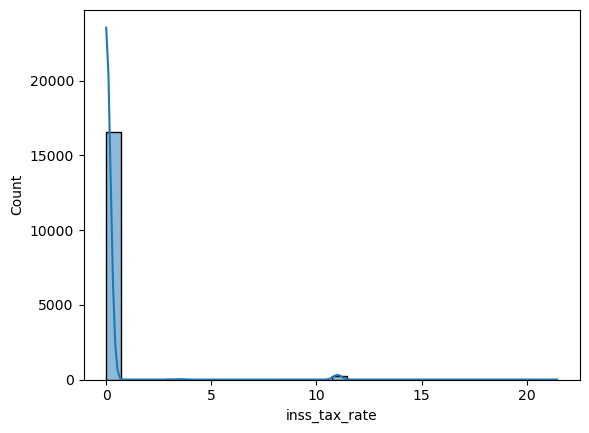

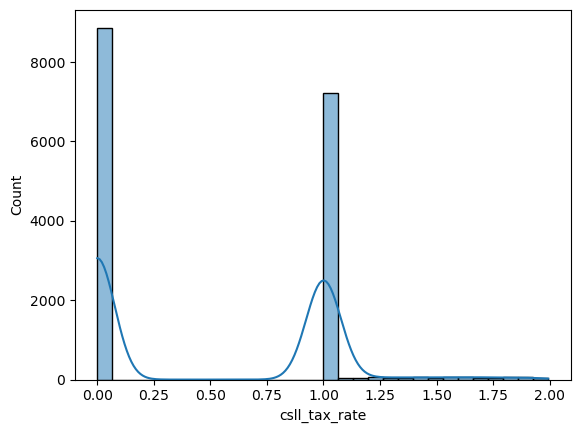

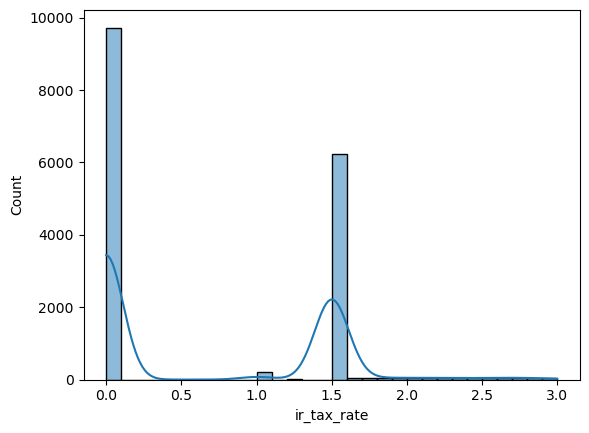

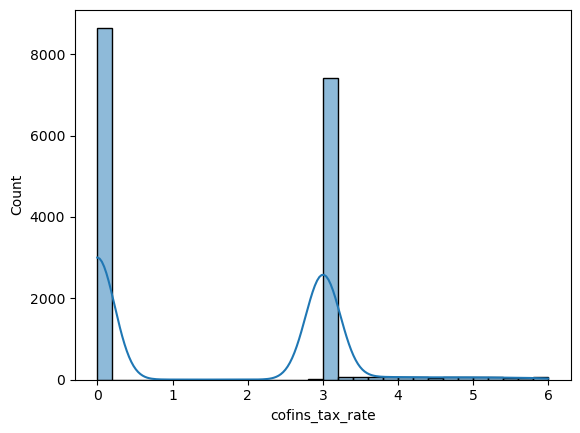

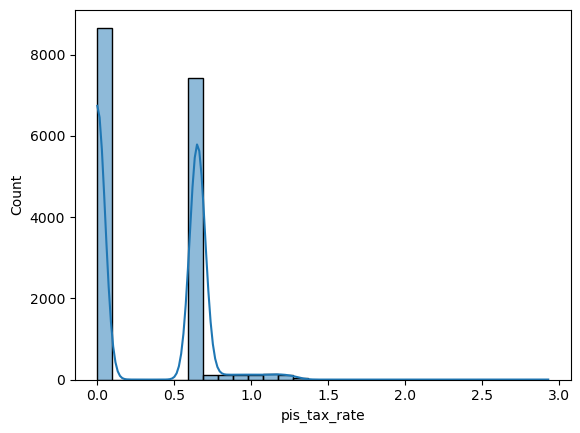

In [16]:
# Histograma de uma variável numérica
for col in num_cols[1:]:
    sns.histplot(df[col], bins=30, kde=True)
    plt.show()

## Visualização dos boxplots

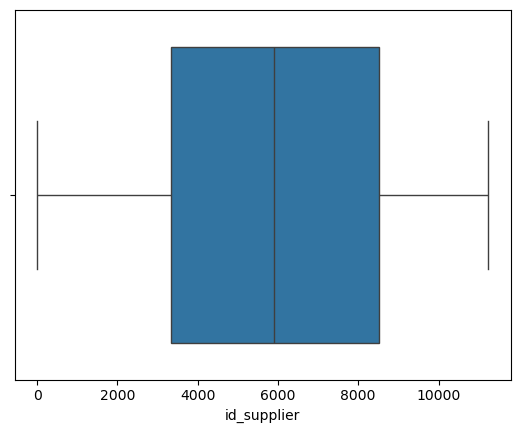

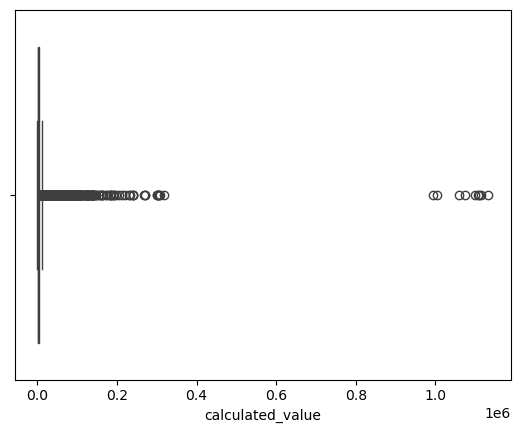

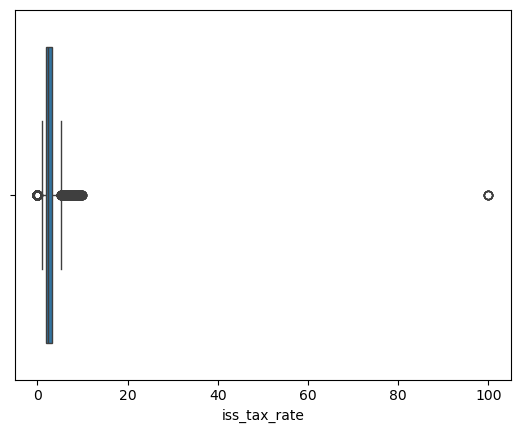

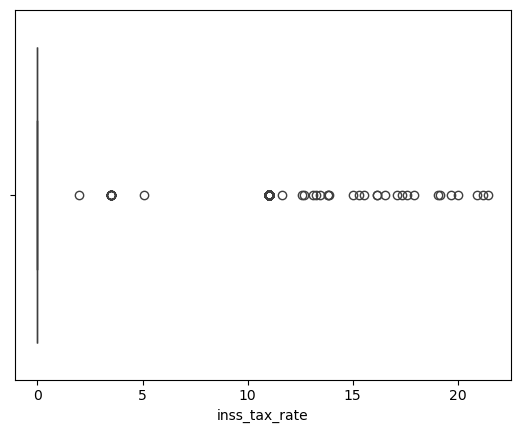

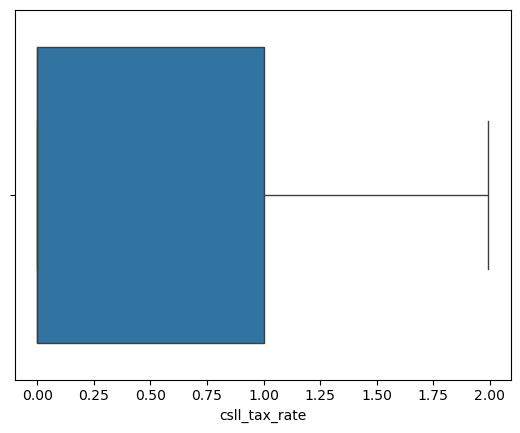

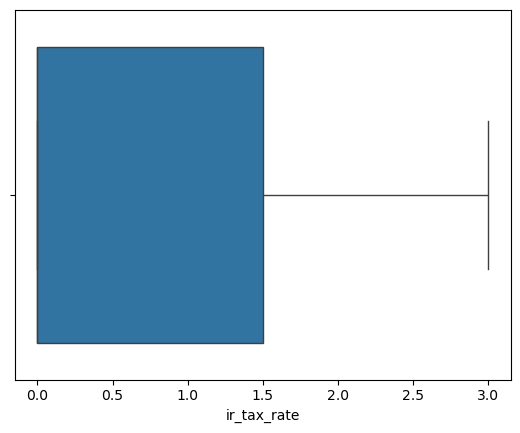

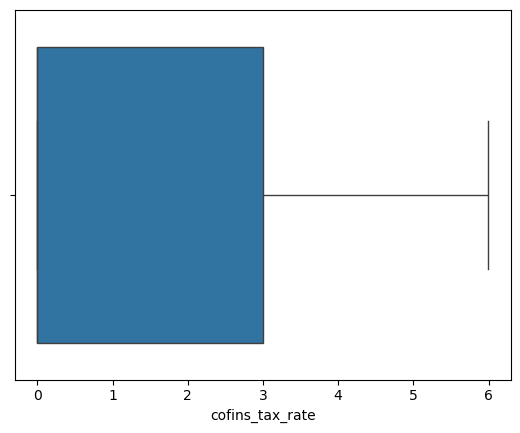

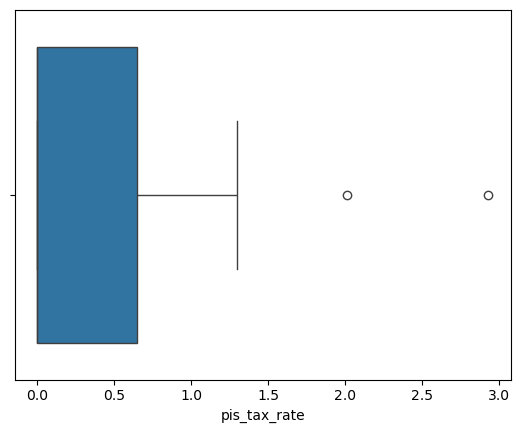

In [17]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.show()

## Relação de Variáveis numéricas e Class Label

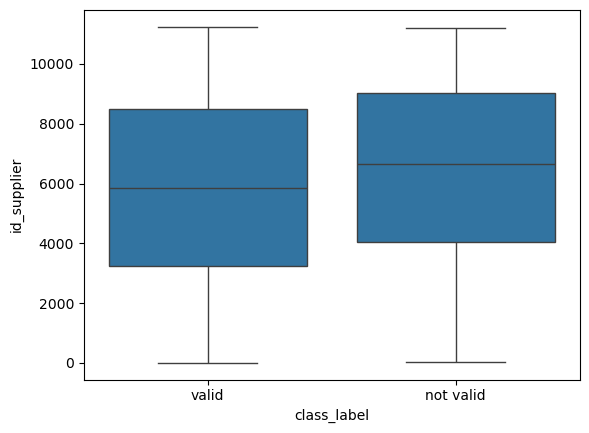

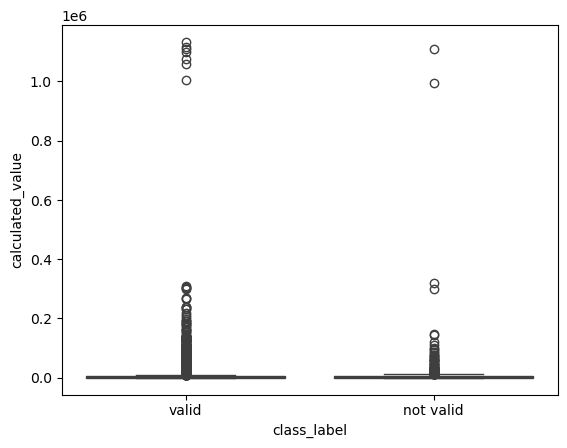

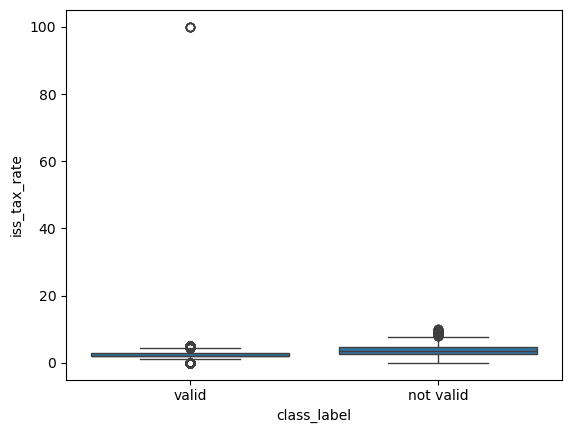

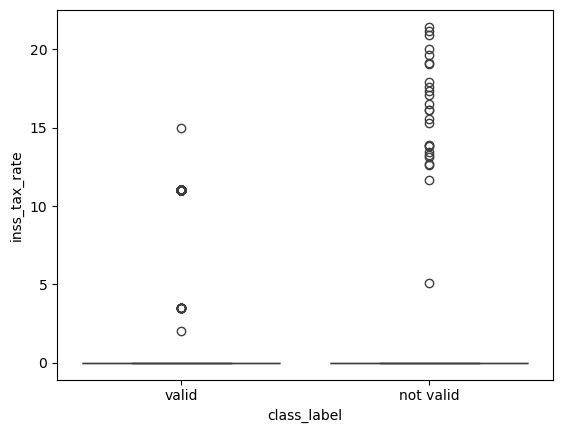

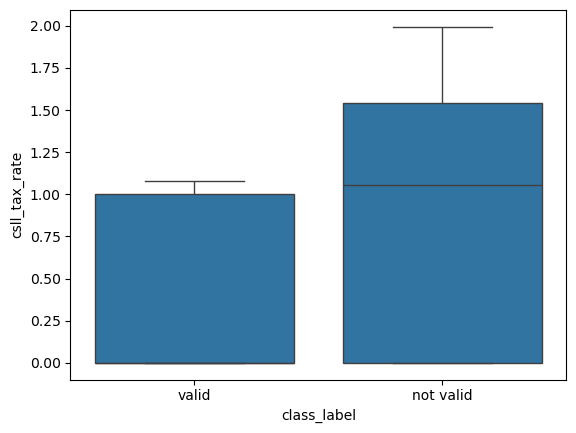

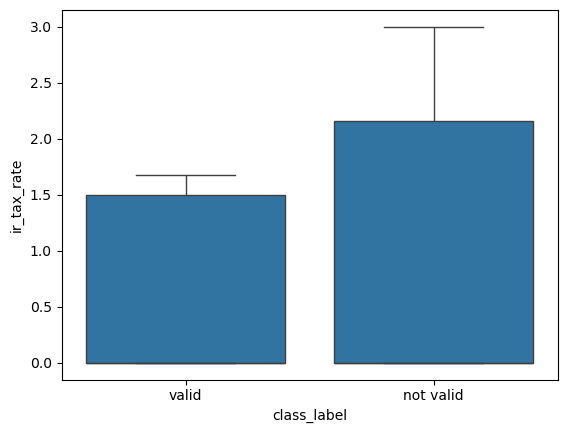

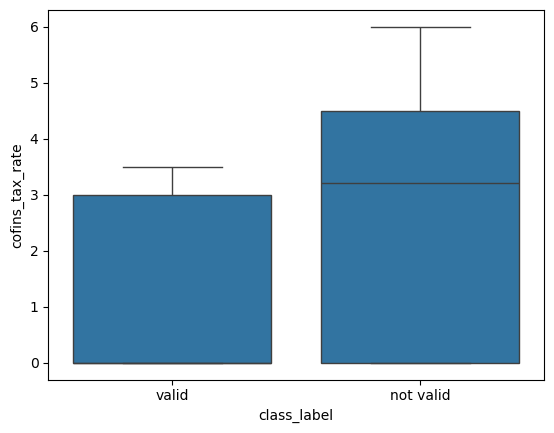

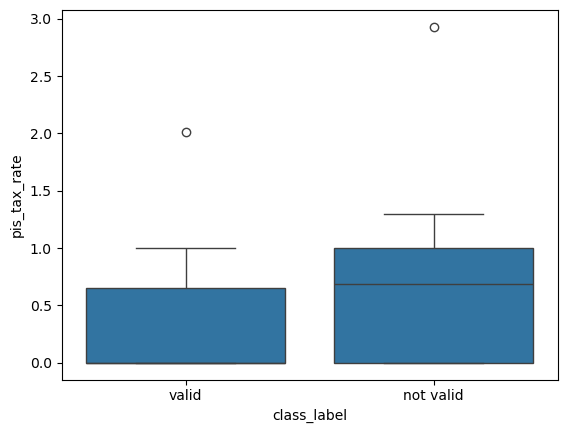

In [82]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    sns.boxplot(x=df["class_label"], y=df[col])
    plt.show()

## Análise da feature Data

In [145]:
def analise_da_data(df_temp, coluna_data):
    df_temp[coluna_data] = pd.to_datetime(df_temp[coluna_data], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")

    df_temp["Ano"] = df_temp[coluna_data].dt.year
    df_temp["Mês"] = df_temp[coluna_data].dt.month
    df_temp["Dia"] = df_temp[coluna_data].dt.day
    df_temp["Hora"] = df_temp[coluna_data].dt.hour
    df_temp["Minuto"] = df_temp[coluna_data].dt.minute
    df_temp["Segundo"] = df_temp[coluna_data].dt.second
    df_temp["Milissegundo"] = df_temp[coluna_data].dt.microsecond // 1000  # Converte microssegundos para milissegundos

    return df_temp.drop('issue_date', axis=1)

df_transformado = analise_da_data(pd.DataFrame(df['issue_date'].copy()), "issue_date")
display(df_transformado)

,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
0,2024,10,14,0,0,0,0
1,2024,10,16,0,0,0,0
2,2024,10,15,16,40,24,0
3,2024,10,17,0,0,0,0
4,2024,10,7,17,4,16,0
...,...,...,...,...,...,...,...
16838,2025,1,1,8,25,39,0
16839,2025,1,7,18,25,37,0
16840,2025,1,3,12,18,11,0
16841,2025,1,8,7,53,52,0


- Análise de valores válidos de cada parte da data

In [123]:
df_transformado.describe()

,Ano,Mês,Dia,Hora,Minuto,Segundo,Milissegundo
count,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.000000,16843.0
mean,2024.024521,10.749985,9.167844,7.076708,16.322983,16.016565,0.0
std,0.155811,1.776394,6.679094,6.909886,19.472983,19.356465,0.0
min,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.0
25%,2024.000000,10.000000,3.000000,0.000000,0.000000,0.000000,0.0
50%,2024.000000,11.000000,8.000000,8.000000,6.000000,5.000000,0.0
75%,2024.000000,12.000000,14.000000,13.000000,33.000000,31.000000,0.0
max,2025.000000,12.000000,31.000000,23.000000,59.000000,59.000000,0.0


- A partir da análise, os valores de data são válidos, porém não há necessidade dessa feature para o treinamento do modelo, visto que eles não influenciam o valor do rótulo.

## Matriz de correlação

In [156]:
# Transforma o rótulo em número
df["class_label"] = df["class_label"].map({"not valid": 0, "valid": 1})

# Quantifica os valores booleanos
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16843 entries, 0 to 16842
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   issue_date                   16843 non-null  object 
 1   id_supplier                  16675 non-null  float64
 2   iss_retention                16843 non-null  int32  
 3   lc116                        16843 non-null  object 
 4   calculated_value             16843 non-null  float64
 5   iss_tax_rate                 16675 non-null  float64
 6   inss_tax_rate                16843 non-null  float64
 7   csll_tax_rate                16843 non-null  float64
 8   ir_tax_rate                  16843 non-null  float64
 9   cofins_tax_rate              16843 non-null  float64
 10  pis_tax_rate                 16843 non-null  float64
 11  opting_for_simples_nacional  16843 non-null  int32  
 12  state                        16675 non-null  object 
 13  class_label     

In [158]:
def imprimirMatrizDeCorr(df_temp): # dataframe temporário
    col_nums = df_temp.select_dtypes(include=["int64", "float64", "int32"]).columns
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_temp[col_nums].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

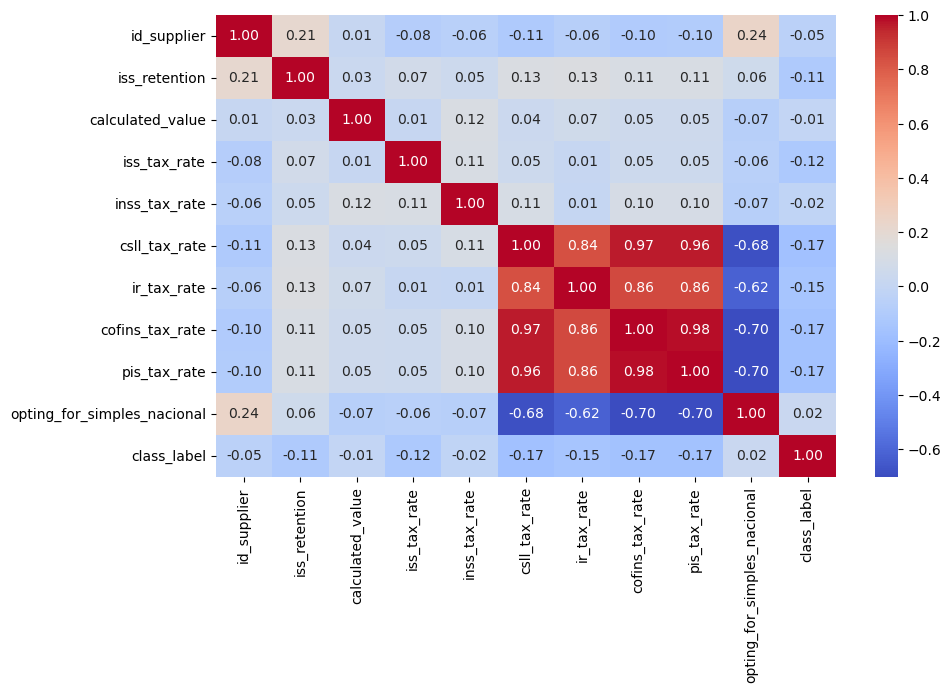

In [159]:
imprimirMatrizDeCorr(df)

- Features cofins_tax_rate, pis_tax_rate e csll_tax_rate estão muito correlacionadas (Multicolinearidade de variáveis).

### Possíveis soluções para multicolinearidade das variáveis

- Cálculo do VIF(Variance Inflation Factor)
  
 Mede a multicolinearidade entre variáveis de um conjunto de dados.

In [162]:
def VIF(df_temp, col_nums):  # O dataframe temporário e as colunas numéricas desse dataframe
    df_num = df_temp[col_nums].dropna()

    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_num.columns
    vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

    print(vif_data)

#### Solução 1 - Remoção de duas das três features correlacionadas

In [165]:
df_sol1 = df.drop("cofins_tax_rate", axis = 1) 

In [166]:
df_sol1= df_sol1.drop(columns=["pis_tax_rate"], axis=1)

In [167]:
col_nums = df_sol1.select_dtypes(include=["int64", "float64", "int32"]).columns
VIF(df_sol1, col_nums)

                       Feature       VIF
0                  id_supplier  4.450501
1                iss_retention  2.744153
2             calculated_value  1.065495
3                 iss_tax_rate  2.233672
4                inss_tax_rate  1.081313
5                csll_tax_rate  7.080565
6                  ir_tax_rate  5.972452
7  opting_for_simples_nacional  2.874952
8                  class_label  4.613514


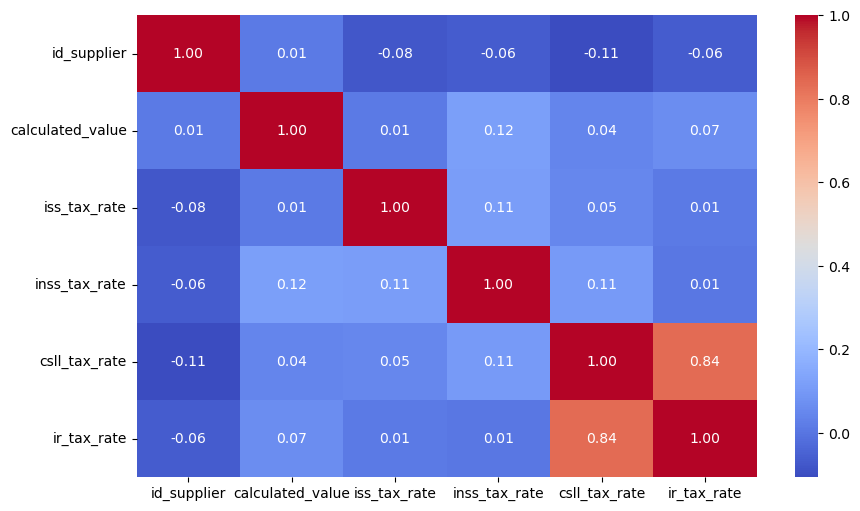

In [65]:
imprimirMatrizDeCorr(df_sol1)

#### Solução 2 - Somatório das features correlacionadas

In [168]:
df_sol2 = df.copy()
df_sol2["total_tax_rate"] = df_sol2["cofins_tax_rate"] + df_sol2["pis_tax_rate"] + df_sol2["csll_tax_rate"]
df_sol2.drop(columns=["cofins_tax_rate", "pis_tax_rate", "csll_tax_rate"], inplace=True)

In [169]:
col_nums = df_sol2.select_dtypes(include=["int64", "float64", "int32"]).columns
VIF(df_sol2, col_nums)

                       Feature       VIF
0                  id_supplier  4.482677
1                iss_retention  2.732262
2             calculated_value  1.063965
3                 iss_tax_rate  2.238245
4                inss_tax_rate  1.084239
5                  ir_tax_rate  6.752161
6  opting_for_simples_nacional  2.952051
7                  class_label  4.667978
8               total_tax_rate  8.469147


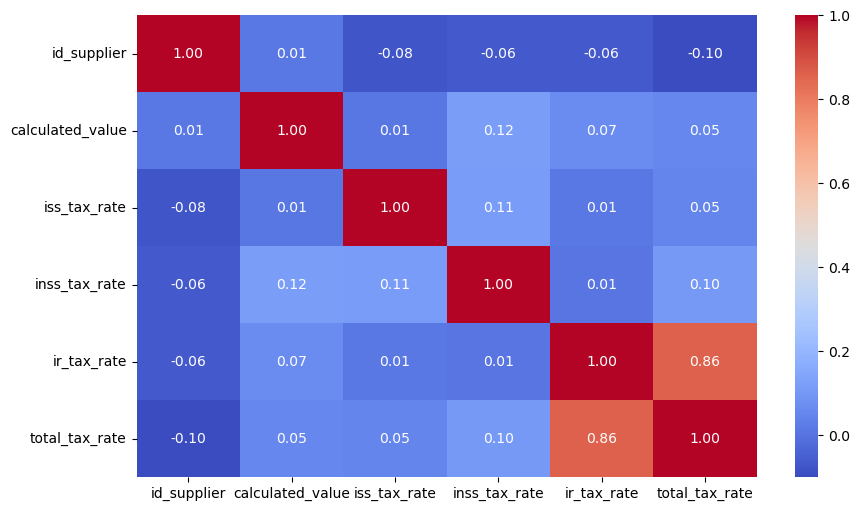

In [66]:
imprimirMatrizDeCorr(df_sol2)

#### Solução 3 - Redução de Dimensionalidade com o PCA

In [170]:
df_sol3 = df.copy()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sol3[["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"]])

pca = PCA(n_components=1)
df_sol3["pca_tax_rate"] = pca.fit_transform(df_scaled)

df_sol3 = df_sol3.drop(columns=["csll_tax_rate", "cofins_tax_rate", "pis_tax_rate"])

In [171]:
col_nums = df_sol3.select_dtypes(include=["int64", "float64", "int32"]).columns
VIF(df_sol3, col_nums)

                       Feature       VIF
0                  id_supplier  4.408401
1                iss_retention  2.711474
2             calculated_value  1.065504
3                 iss_tax_rate  2.203391
4                inss_tax_rate  1.080912
5                  ir_tax_rate  5.923118
6  opting_for_simples_nacional  3.314648
7                  class_label  4.928807
8                 pca_tax_rate  4.880538


- Verificação se houve perda de informações

In [172]:
pca.explained_variance_ratio_

array([0.98037141])

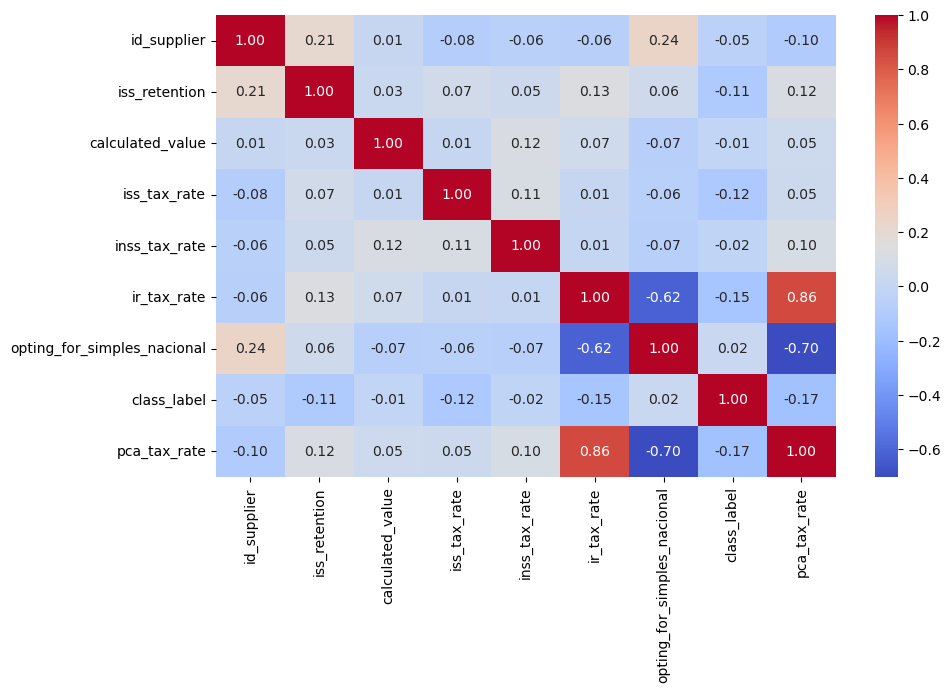

In [173]:
imprimirMatrizDeCorr(df_sol3)

# Pré-processamento de Dados

- Definição do DataFrame que será utilizado nos modelos (ignora as modificações da análise)

In [229]:
df = df_bruto.copy()

## Limpeza de Dados

- Remoção dos dados faltantes das features categóricas

In [230]:
df = df.dropna(subset=["id_supplier", "state"])

- Visualização dos dados faltantes restantes

Com a remoção das amostras ausentes, os valores ausentes da feature "iss_tax_rate" foram removidos também.

In [231]:
df.isnull().sum()

id                             0
issue_date                     0
id_supplier                    0
iss_retention                  0
lc116                          0
calculated_value               0
iss_tax_rate                   0
inss_tax_rate                  0
csll_tax_rate                  0
ir_tax_rate                    0
cofins_tax_rate                0
pis_tax_rate                   0
opting_for_simples_nacional    0
state                          0
class_label                    0
dtype: int64

## Engenharia de Features

### Remoção da coluna ID

In [232]:
df = df.drop('id', axis = 1)
df

,issue_date,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,2024-10-14 00:00:00.000,7101.0,True,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
1,2024-10-16 00:00:00.000,5839.0,True,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,True,AM,not valid
2,2024-10-15 16:40:24.000,974.0,False,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,False,PA,valid
3,2024-10-17 00:00:00.000,9099.0,True,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,True,PA,valid
4,2024-10-07 17:04:16.000,3434.0,False,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,2025-01-01 08:25:39.000,11010.0,False,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,False,AM,valid
16839,2025-01-07 18:25:37.000,6460.0,False,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,True,AM,valid
16840,2025-01-03 12:18:11.000,769.0,False,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,False,AM,valid
16841,2025-01-08 07:53:52.000,4822.0,False,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,False,AC,valid


### Remoção da coluna de data

In [233]:
df = df.drop('issue_date', axis = 1)

### Correção do tipo da variável lc116

In [234]:
df['lc116'] = df['lc116'].astype(str)

### Codificação de Variáveis Categóricas

- Codificação de variáveis booleanas

In [235]:
bool_cols = df.select_dtypes(include=["bool"]).columns
df[bool_cols] = df[bool_cols].astype(int)
df

,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,7101.0,1,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,PA,valid
1,5839.0,1,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,AM,not valid
2,974.0,0,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,PA,valid
3,9099.0,1,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,PA,valid
4,3434.0,0,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,AM,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,AM,valid
16839,6460.0,0,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,AM,valid
16840,769.0,0,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,AM,valid
16841,4822.0,0,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,AC,valid


- Codificação da class_label como booleana

In [236]:
df["class_label"] = df["class_label"].map({"not valid": 0, "valid": 1})
df

,id_supplier,iss_retention,lc116,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,state,class_label
0,7101.0,1,4.03,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,PA,1
1,5839.0,1,4.12,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,AM,0
2,974.0,0,10.02,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,PA,1
3,9099.0,1,4.03,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,PA,1
4,3434.0,0,4.09,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,AM,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,1.07,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,AM,1
16839,6460.0,0,16.01,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,AM,1
16840,769.0,0,1.07,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,AM,1
16841,4822.0,0,4.02,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,AC,1


- Codificação das demais variáveis categóricas

In [237]:
cat_cols = df.select_dtypes(include=["object"]).columns
df = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)
df

,id_supplier,iss_retention,calculated_value,iss_tax_rate,inss_tax_rate,csll_tax_rate,ir_tax_rate,cofins_tax_rate,pis_tax_rate,opting_for_simples_nacional,...,lc116_7.12,lc116_7.13,lc116_8.02,lc116_9.01,lc116_9.02,lc116_99.99,state_AM,state_PA,state_RO,state_RR
0,7101.0,1,1255.6188,2.000000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,0,1,0,0
1,5839.0,1,749.5614,2.581523,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,1,0,0,0
2,974.0,0,620.2056,2.000000,0.0,0.0,0.0,0.0,0.00,0,...,0,0,0,0,0,0,0,1,0,0
3,9099.0,1,155.4390,3.140000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,0,1,0,0
4,3434.0,0,5520.5754,0.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16838,11010.0,0,2.7987,2.000000,0.0,0.0,0.0,0.0,0.00,0,...,0,0,0,0,0,0,1,0,0,0
16839,6460.0,0,712.5000,0.000000,0.0,0.0,0.0,0.0,0.00,1,...,0,0,0,0,0,0,1,0,0,0
16840,769.0,0,1983.0357,2.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,1,0,0,0
16841,4822.0,0,969.0000,2.000000,0.0,1.0,1.5,3.0,0.65,0,...,0,0,0,0,0,0,0,0,0,0


- Verificação dos tipos de variáveis após a codificação de variáveis

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16675 entries, 0 to 16842
Columns: 132 entries, id_supplier to state_RR
dtypes: float64(8), int32(123), int64(1)
memory usage: 9.1 MB


## Divisão do Dataset

In [239]:
X = df.drop('class_label', axis=1)
y = df['class_label']

- Divisão do dataset de 70% para treino, 20% de validação e 10% teste

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [247]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Modelos de Classificação

- Random Forest: fácil de interpretar, rápido no treino, lida bem com outliers e gera relatório de importância das features.
- XGBoost: Eficientes em dados tabulares, rápido, robusto e gera relatório de importância das features.

## Random Forest

In [250]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

### Importância das Variáveis

In [251]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Apresentação
for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(name, ":", imp)

iss_tax_rate : 0.16480757220341086
state_PA : 0.15424287519594954
cofins_tax_rate : 0.1217069071590845
pis_tax_rate : 0.11723754023549667
csll_tax_rate : 0.10335295005969176
ir_tax_rate : 0.09004927960203313
state_RO : 0.03844613312877623
id_supplier : 0.03666688517864634
calculated_value : 0.03214857088788883
lc116_4.03 : 0.019168455350904955
opting_for_simples_nacional : 0.016561347171675327
lc116_4.01 : 0.011675500392215576
state_AM : 0.010534335575265707
iss_retention : 0.010483891801361717
lc116_14.01 : 0.00876427766726392
lc116_1.05 : 0.007169360686934419
lc116_4.02 : 0.003372461106480117
lc116_1.07 : 0.002916495032075017
lc116_17.01 : 0.0024483413923372397
state_RR : 0.0024166511105625024
lc116_10.08 : 0.0023118306546391653
lc116_26.01 : 0.0019397650838443882
lc116_17.09 : 0.0018931930752119721
lc116_17.06 : 0.0016964685055605496
lc116_4.06 : 0.001692809623110834
lc116_14.02 : 0.0016631614912620434
inss_tax_rate : 0.001628692254228616
lc116_13.03 : 0.0016042425211122283
lc116_7.

## XGBoost

In [252]:
xgb_model = xgb.XGBClassifier(random_state=42, scale_pos_weight=10)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Importância das Variáveis

<Figure size 1200x800 with 0 Axes>

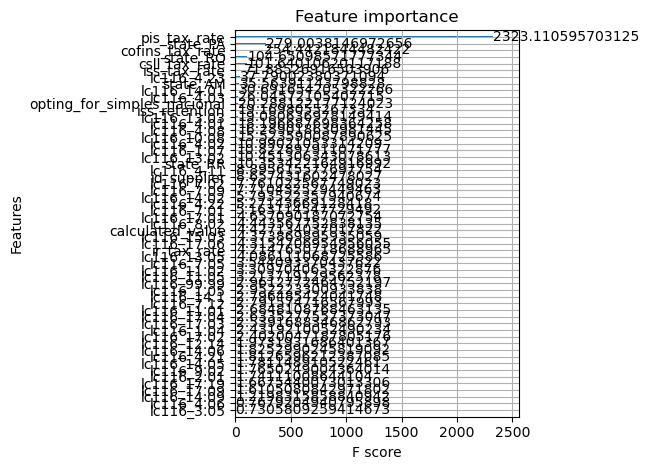

In [253]:
plt.figure(figsize=(12, 8)) 
xgb.plot_importance(xgb_model, importance_type="gain")
plt.tight_layout() 
plt.show()

# Medição de Latência do Modelo:

- Número de amostras para teste de latência e número de repetições para calcular a média

In [215]:
num_samples = X_test.shape[0]
n_repeticoes = 10  # Número de repetições para calcular a média
num_samples

5003

- Medição de tempo do Random Forest

In [256]:
rf_latencias = []
for _ in range(n_repeticoes):
    inicio = time.perf_counter()
    rf.predict(X_test)
    rf_latencias.append((time.perf_counter() - inicio) / num_samples)

rf_latency_media = np.mean(rf_latencias)
print(f"Latência média do Random Forest: {rf_latency_media:.6f} segundos por amostra")

Latência média do Random Forest: 0.000034 segundos por amostra


- Medição de tempo do XGBoost

In [257]:
xgb_latencias = []
for _ in range(n_repeticoes):
    inicio = time.perf_counter()
    xgb_model.predict(X_test)
    xgb_latencias.append((time.perf_counter() - inicio) / num_samples)

xgb_latency_media = np.mean(xgb_latencias)
print(f"Latência média do XGBoost: {xgb_latency_media:.6f} segundos por amostra")

Latência média do XGBoost: 0.000026 segundos por amostra


# Avaliação dos Modelos

In [221]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)

    prec = precision_score(y_test, y_pred)

    rec = recall_score(y_test, y_pred)

    f1 = f1_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_proba)

    print("Avaliação do Modelo")
    print("Accuracy       :", round(acc, 3))
    print("Precision      :", round(prec, 3))
    print("Recall         :", round(rec, 3))
    print("F1 Score       :", round(f1, 3))
    print("ROC AUC        :", round(roc_auc, 3))
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

## Random Forest

Avaliação do Modelo
Accuracy       : 0.978
Precision      : 0.986
Recall         : 0.99
F1 Score       : 0.988
ROC AUC        : 0.989

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       436
           1       0.99      0.99      0.99      4567

    accuracy                           0.98      5003
   macro avg       0.94      0.92      0.93      5003
weighted avg       0.98      0.98      0.98      5003



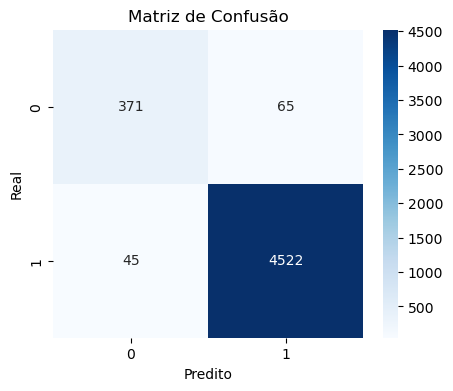

In [254]:
evaluate_model(rf, X_test, y_test)

## XGBoost

Avaliação do Modelo
Accuracy       : 0.983
Precision      : 0.984
Recall         : 0.997
F1 Score       : 0.991
ROC AUC        : 0.995

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.97      0.83      0.89       436
           1       0.98      1.00      0.99      4567

    accuracy                           0.98      5003
   macro avg       0.98      0.91      0.94      5003
weighted avg       0.98      0.98      0.98      5003



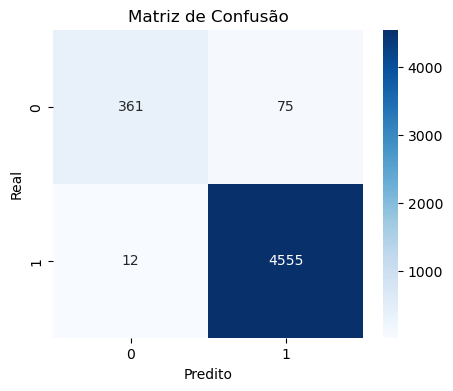

In [255]:
evaluate_model(xgb_model, X_test, y_test)

# Experimentos

Foram realizados experimentos: removendo variáveis, alterando valores, normalizando dados, etc.
- Sobre os experimentos, os modelos foram avaliados com:
    - todas as features do dataset.
    - sem as features correlacionadas (cofins_tax_rate, pis_tax_rate e csll_tax_rate).
    - sem a data.
    - sem a feature lc116.
  
Todos os resultados foram semelhantes: mais de 97% de acerto para cada métrica avaliada. Apesar das métricas terem sidos altas, quando as métricas para cada rótulo foram analisadas, o desbalanceamento se tornou mais evidente, visto que para a classe 0 (not valid) o resultado das métricas recall e f1-score foi um pouco diferente quando comparado com as métricas do rótulo 1 (valid), que era classe majoritária (cerca de mais de 15% de diferença).

- Uso do GridSearch:
De modo geral, os resultados não apresentaram muita diferença, variava 1% de um rótulo e aumentava 1% do outro. Desse modo, resolvi permanecer sem o GridSearch e utilizando os valores padrões de cada modelo.

- RandomForest no GridSearch:
    - 'max_depth': Profundidade da árvore.
    - 'min_samples_split': Mínimo de amostras para dividir um nó.
    - 'min_samples_leaf': Mínimo de amostras por folha.
    - 'max_features': Número de features por divisão.

- XGBoost no GridSearch:
    - 'max_depth': Profundidade da árvore.
    - 'learning_rate': Taxa de aprendizado.
    - 'subsample': Amostragem dos dados para cada árvore.

# Aplicação do Modelo

 Integração do modelo aos fluxos de trabalho do cliente.

- Criação de uma API para o modelo.
- Ao cadastrar uma nova nota fiscal, a API do modelo é chamada e o resultado é apresentado.
- Se a nota fiscal for inválida, então um alerta é lançado para ser avaliada manualmente.

De modo geral, caso uma nota fiscal seja dita como inválida, será ainda necessário uma verificação manual para garantir a informação. Apesar dessa verificação manual, o modelo consegueria economizar muito tempo classificando as demais notas fiscais.